In [4]:
import os
os.chdir("/Users/andrewluckritz/Documents/IT4970/ThreatKit/ThreatKit")
os.getcwd()

'/Users/andrewluckritz/Documents/IT4970/ThreatKit/ThreatKit'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
    auc,
    classification_report
)

# Load evaluation results from ThreatKit offline eval
results_path = "threatkit/emailcheck/eval/eval_results.csv"
df = pd.read_csv(results_path)

# Basic sanity check
df.head()

,subject,from,return_path,to,body,label,raw_score,score_0_5,pred_phish
0,Wire transfer authorization required,notifications@accounts.example-pay.com,NaN,user@example.com,Your subscription renewal failed. Update payme...,1,0.8,0.8,1
1,Password reset required,finance@mail.example-security.com,NaN,user@example.com,Your package is held by customs. Pay the custo...,1,0.8,0.8,1
2,Facilities maintenance schedule,billing@dept.university.edu,NaN,user@example.com,"Hello,\n\nReminder for tomorrow's standup at 9...",0,5.0,5.0,0
3,Password reset required,service@service.notifications.com,NaN,user@example.com,You reached 99% of your mailbox quota. Increas...,1,1.8,1.8,1
4,Your package is being held - pay customs,news@service.notifications.com,NaN,user@example.com,You reached 99% of your mailbox quota. Increas...,1,1.8,1.8,1


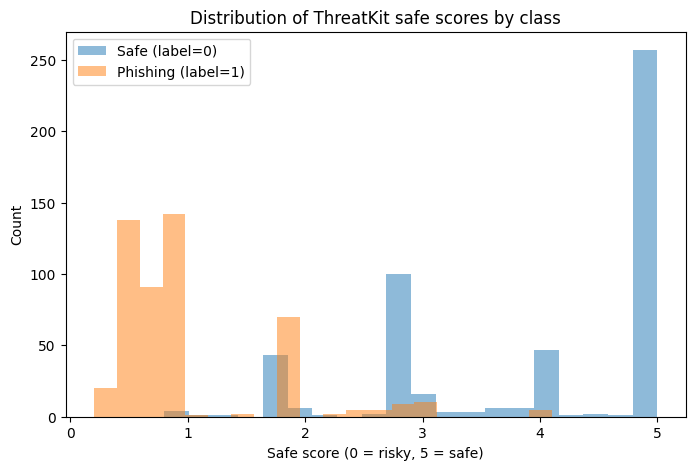

In [6]:
plt.figure(figsize=(8, 5))

phish_scores = df[df["label"] == 1]["score_0_5"]
safe_scores  = df[df["label"] == 0]["score_0_5"]

plt.hist(safe_scores, bins=20, alpha=0.5, label="Safe (label=0)")
plt.hist(phish_scores, bins=20, alpha=0.5, label="Phishing (label=1)")

plt.xlabel("Safe score (0 = risky, 5 = safe)")
plt.ylabel("Count")
plt.title("Distribution of ThreatKit safe scores by class")
plt.legend()
plt.show()

Accuracy : 0.818
Precision: 0.7366071428571429
Recall   : 0.99
F1-score : 0.8447098976109215

Classification report:
              precision    recall  f1-score   support

           0     0.9848    0.6460    0.7802       500
           1     0.7366    0.9900    0.8447       500

    accuracy                         0.8180      1000
   macro avg     0.8607    0.8180    0.8125      1000
weighted avg     0.8607    0.8180    0.8125      1000



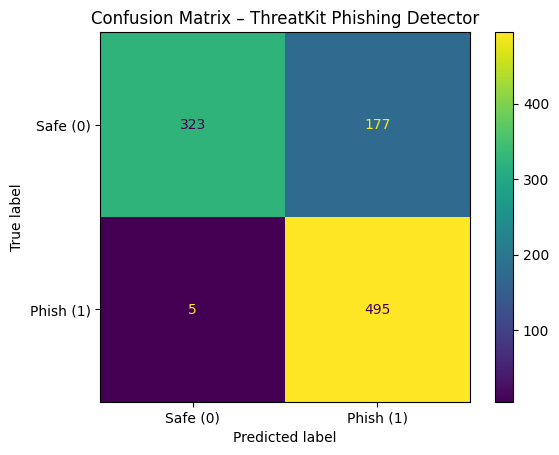

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = df["label"].values
y_pred = df["pred_phish"].values

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print()
print("Classification report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe (0)", "Phish (1)"])
disp.plot()
plt.title("Confusion Matrix – ThreatKit Phishing Detector")
plt.show()

In [ ]:
# Approximate phishing probability from safe score
safe = df["score_0_5"].values
p_phish = 1.0 - (safe / 5.0)

fpr, tpr, thresholds = roc_curve(y_true, p_phish)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – ThreatKit Phishing Detector")
plt.legend()
plt.axis("square")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_thresholds(scores, labels, thresholds):
    rows = []
    for t in thresholds:
        preds = (scores < t).astype(int)  # phishing if safe_score < t
        rows.append({
            "threshold": t,
            "accuracy": accuracy_score(labels, preds),
            "precision": precision_score(labels, preds, zero_division=0),
            "recall": recall_score(labels, preds, zero_division=0),
            "f1": f1_score(labels, preds, zero_division=0),
        })
    return pd.DataFrame(rows)

thresholds = np.arange(2.0, 4.6, 0.25)
sweep_df = evaluate_thresholds(df["score_0_5"].values, y_true, thresholds)
sweep_df

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(sweep_df["threshold"], sweep_df["accuracy"], marker="o", label="Accuracy")
plt.plot(sweep_df["threshold"], sweep_df["precision"], marker="o", label="Precision")
plt.plot(sweep_df["threshold"], sweep_df["recall"], marker="o", label="Recall")
plt.plot(sweep_df["threshold"], sweep_df["f1"], marker="o", label="F1-score")

plt.axvline(4.0, linestyle="--", label="Chosen threshold (4.0)")

plt.xlabel("Safe score threshold t (score < t ⇒ phishing)")
plt.ylabel("Metric value")
plt.title("Metric trade-offs vs threshold")
plt.legend()
plt.grid(True)
plt.show()